In [89]:
import os
from glob import glob
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

from sklearn.metrics import roc_auc_score

In [90]:

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.style.use('dark_background')

display(HTML("<style>"
    + "#notebook { padding-top:0px; } " ""
    + ".container { width:100%; } "
    + ".end_space { min-height:0px; } "
    + "</style>"))

In [91]:
logs_path = 'C:\\Users\\emace\\AImageLab\\SRV-Continual\\results\\canomaly\\logs'

In [92]:
for environment in glob(logs_path + '/**/*.pyd', recursive=True):
    with open(environment, 'r') as f:
        experiments = [literal_eval(line) for line in f.readlines()]

In [93]:
def print_exp_info(exp: dict):
    print({k: exp[k] for k in exp if k not in ['logs', 'results', 'knowledge']})

In [94]:
# usage example:  show_exp_images(experiments[0], True)
def show_exp_images(exp: dict, show_origins=False):
    for task in exp['results']:
        cur_images = exp['results'][task]['images']
        fig, axs = plt.subplots(2, 5, figsize=(15, 8))
        fig.suptitle(f'TASK {task}', fontsize=30)
        for r, row in enumerate(axs):
            for c, cell in enumerate(row):
                idx = r*5 + c
                image = np.zeros((28, 28, 3), dtype=float)
                cell.set_title(cur_images[idx]['label'])
                orig = np.array(cur_images[idx]['original'][0])
                recon = np.array(cur_images[idx]['reconstruction'][0]).clip(0, 1)
                if show_origins:
                    image[:,:,1] = orig
                image[:,:,0] = recon
                image[:,:,2] = recon
                cell.imshow(image)
        plt.show()

In [95]:
def compute_weighted_auc(anomalies: np.array, scores: np.array):
    n_anomalies = anomalies.sum().item()
    n_normals = len(anomalies) - n_anomalies
    weights = np.zeros_like(scores)
    weights[anomalies == 0] = n_anomalies/len(anomalies)
    weights[anomalies == 1] = n_normals/len(anomalies)
    return roc_auc_score(anomalies, scores, sample_weight=weights)


def compute_all_aucs(anomalies, scores):
    total_auc = roc_auc_score(anomalies, scores)

    n_anomalies = anomalies.sum().item()
    n_normals = len(anomalies) - n_anomalies
    weighted_auc = compute_weighted_auc(anomalies, scores)

    min_label = 1 if n_anomalies < n_normals else 0
    max_label = 1 - min_label
    n_per_class = n_anomalies if n_anomalies < n_normals else n_normals
    idxs_norm = np.where(anomalies==min_label)[0]
    idxs_anom = np.random.choice(np.where(anomalies==max_label)[0], size=n_per_class, replace=False)
    idxs = np.concatenate((idxs_norm, idxs_anom))
    balanced_auc = roc_auc_score(anomalies[idxs], scores[idxs])

    return total_auc, weighted_auc, balanced_auc

In [147]:
def compute_exp_metrics(exp: dict, per_task=True):
    knowledge = []
    metrics = pd.DataFrame(index=exp['results'], columns=[str(labels) for labels in exp['knowledge'].values()] + ['total'], dtype='float')
    for t, task in enumerate(exp['results']):
        knowledge.extend(exp['knowledge'][task])
        targets = np.array(exp['results'][task]['targets'])
        scores = np.array(exp['results'][task]['rec_errs'])
        anomalies = (~np.isin(targets, knowledge)).astype(int)
        auc = compute_weighted_auc(anomalies, scores)
        metrics.loc[task, 'total'] = auc
        # print(f'task {task}: {auc}')

        if t > 0 and per_task:
            for in_t, in_task in zip(range(t+1), exp['results']):
                np_knowledge = np.array(knowledge)
                excluded_labels = np_knowledge[~np.isin(np_knowledge, exp['knowledge'][in_task])].tolist()
                mask = ~np.isin(targets, excluded_labels)
                in_targets = targets[mask]
                in_scores = scores[mask]
                in_anomalies = (~np.isin(in_targets, knowledge)).astype(int)
                in_auc = compute_weighted_auc(in_anomalies, in_scores)
                metrics.loc[task, str(exp['knowledge'][in_task])] = in_auc
                # print(f'  t{in_task} vs all: {in_auc}')
        else:
            metrics.loc[task, str(exp['knowledge'][task])] = auc

    final_auc = metrics.loc[task, 'total']
    average_auc = metrics.loc[:, "total"].mean()
    # print(f'final {final_auc} average {average_auc}')
    return final_auc, average_auc, metrics

def show_aucs_per_task(task_aucs: pd.DataFrame):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.heatmap(task_aucs, annot=True, ax=ax, cmap='Reds', cbar=False)
    plt.ylabel('Task')
    plt.xlabel('Class')
    plt.title('Auc per task and class')


In [117]:
def reconstruction_confusion_matrix(exp: dict):
    matrix = pd.DataFrame(index=exp['results'], columns=[str(x) for x in exp['knowledge'].values()], dtype='float')

    for task in exp['results']:
        scores = np.array(exp['results'][task]['rec_errs'])
        targets = np.array(exp['results'][task]['targets'])
        for targ in exp['knowledge']:
            matrix.loc[task, str(exp['knowledge'][targ])] = scores[np.isin(targets, exp['knowledge'][targ])].mean()

    return matrix

def show_conf_matrix(cmatrix: pd.DataFrame):
    fig,ax = plt.subplots(figsize=(10,10))
    sns.heatmap(data=cmatrix, ax=ax,annot=True, cbar=False, cmap='Reds')
    plt.ylabel('Task')
    plt.xlabel('Class')
    plt.title('Reconstruction error per task and class')

{'seed': 2582786278, 'dataset': 'can-mnist', 'model': 'ae', 'optim': 'SGD', 'lr': 0.1, 'joint': False, 'batch_size': 16, 'n_epochs': 1, 'latent_space': 32, 'classes_per_task': 1, 'id': 'c93168de-e96f-4054-828f-c0bbb57b93f6', 'timestamp': '2022-01-26 15:20:08.663516'}
final 0.4215393678008238 average 0.642691277194256


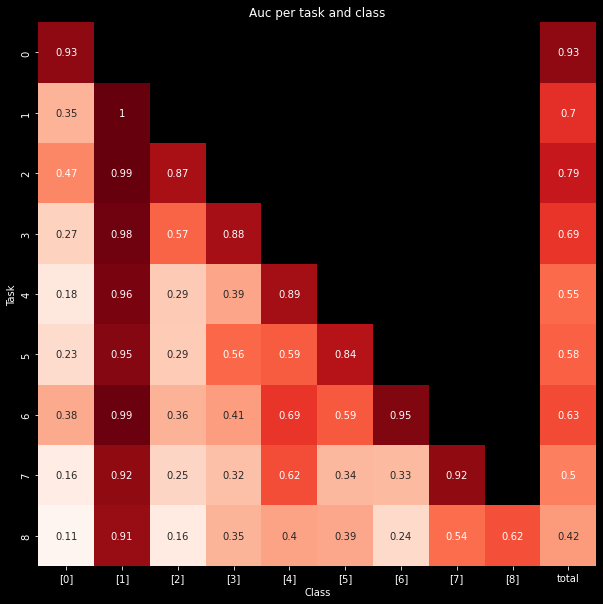

In [148]:
## print metrics of experiments

exp = experiments[0]

print_exp_info(exp)

# show_exp_images(exp, False)

final_auc, average_auc, task_aucs =  compute_exp_metrics(exp)
print(f'final {final_auc} average {average_auc}')
show_aucs_per_task(task_aucs)

cmatrix = reconstruction_confusion_matrix(exp)
# show_conf_matrix(cmatrix)


In [128]:
task_aucs.to_dict(orient='index')
pd.DataFrame.from_dict(task_aucs.to_dict(orient='index'), orient='index')

,[0],[1],[2],[3],[4],[5],[6],[7],[8],total
0,0.927193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.927193
1,0.354900,0.997547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.699772
2,0.472903,0.994955,0.873892,NaN,NaN,NaN,NaN,NaN,NaN,0.792683
3,0.265787,0.981856,0.571136,0.883174,NaN,NaN,NaN,NaN,NaN,0.687105
4,0.184990,0.964371,0.290385,0.394244,0.887986,NaN,NaN,NaN,NaN,0.553749
5,0.232182,0.945211,0.285398,0.558301,0.590751,0.837879,NaN,NaN,NaN,0.578059
6,0.379133,0.987292,0.356803,0.413080,0.688482,0.592551,0.950969,NaN,NaN,0.628592
7,0.157198,0.924661,0.253264,0.319134,0.624273,0.341928,0.332296,0.923190,NaN,0.495529
8,0.110313,0.909266,0.162484,0.349502,0.399294,0.386639,0.241073,0.544022,0.618136,0.421539


In [135]:
from argparse import ArgumentParser
parser = ArgumentParser()
parser.add_argument('--pippo', default='ciao')
args = parser.parse_known_args()[0]

print(args)
log = vars(args)
print('log -> ' + str(log))
log['pluto'] = 'no'
print(args)


Namespace(pippo='ciao')
log -> {'pippo': 'ciao'}
Namespace(pippo='ciao', pluto='no')
